# $Final \hspace{2mm} Project:  Two \hspace{2mm} Sigma \hspace{2mm} Connect - Rental\hspace{2mm} Listing \hspace{2mm}Inquiries$

# Business Understanding

Data has been provided by Renthop.com on a series of listings in New York City.  Renthop is a leading electronic marketplace where NYC housing postings are updated.  As arguably the most efficient real estate market in the country, supply and demand has found a higher efficacy in electronic matching followed by one or two viewings, greatly reducing the need for consumer agents.  Posters on Renthop can submit various information ranging from text descriptions to photos.  Two Sigma, a quantitative money manager with a venture capital arm, is a majority investor in RentHop and has released example data of a standardized feature set and associated "interest" levels.  The goal of the study is to create a model that has predictive power in determining a 3-level classification problem.  The target variable of "Interest", takes on values of low, medium, and high. 

Interestingly, RentHop as a business primarily draws revenue from posters, many of which are major management holding companies with portfolios of numerous buildings.  The value then in being able to predict interest could potentially lead to price tiering, making the service more cost efficient.  A possible rationale is that the postings that are forecasted to have higher interest could be deemed more valuable (assuming some sort of incentive from successfully filling as listing) or be recognized as needing less advertising (lower cost).  A more complete understanding of possible business incentives would be supported with more insight into the RentHop business model.


A test file of data sans labels is provided for submission grading.  Results are scored based on a multi-class logarthmic loss function, specifically:

$$logloss = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M}y_{i,j}log(p_{i,j})$$

For every test sample, a probability must be produced for each class.  The requirement that probabilities sum to 1 is relaxed as they will be scaled to equal 1 by Kaggle prior to scoring.   We believe that the most effective approach to practice the methods learned in this class is to focus on feature construction and understand results while sacrificing classifier selection.  Examination of some of the published kernels in Kaggle show submissions with an extensive use of more complex classifiers and optimization.  We will primarily focus on multi-class logistic regressions and attempt to minimize the logloss with the intent that a good model construction can be later augmented by playing with other classifiers.

# Data Understanding

Usually this section of the CRISP-DM framework would begin with a detailed description of how data was collected.  As this was a contest sponsored by Kaggle, a train and test data set were provided by RentHop.  We will spend a little time describing the data, but a large part of our data exploration consisted of reading the EDA kernels that were published on the contest page. We prefer to instead more of our time discussing the actual model process.

The train data file has 49,352 observations of 14 feature variables as well as the one target variable.  Because the test file is significantly bigger, 74,659 observations, and given that we can use the Kaggle submission scoring as a means of model refining, we decide to use a "dev set" for modelling purposes, but reincorporate into the training for test submission.  With no Nans present in either the train or test files, we include an assumption that there will not be any in the data going forward.  However, we do note that some of the variables are allowed to have empty values where the poster chose not to include any information.

In [1]:
%run LoadFiles/EDAVaraibleShows.py
train_file.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


Examining the data types we find that there are 6 strictly numerical columns as well as 8 object types.  These vary from date times to text to lists.  Below shows a summary of the numerical columns. Something to immediately note is that not all values are present for the latitude and longitude as values of 0 do not correspond to NYC. 

In [34]:
train_data.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


One interesting point that we felt should be made in the data description section is the heavy bias toward low interest data rows.  We expect that this may influence or modelling process and will have to adjust accordingly.  We further see that cost seems to be a limiting factor in interest, i.e. there are high priced, low interest listings but really all medium interest listings fall under 10k, and high interest listings fall under ~7.5k.

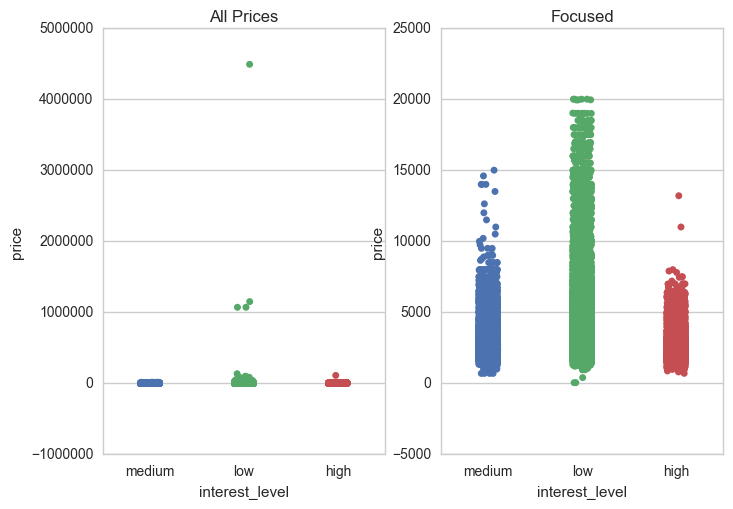

In [40]:
%run LoadFiles/InterestLevelPerPrice.py

# Data Preparation and Modelling

While a normal CRISP-DM document might only focus on the final proposed model becuase this is an academic final, we feel that a summary of the steps and work done along the way is more germane to our grade rather than just trying to support one end model.

An intuitive first step would be start with a base logistic regression model and successively add numerical columns to the data.  We attempt to extract more useful information by first adding a CountFeature and CountPhoto column as well as scaling longitude and latitude using a Min-Max scaling, adjusting out the zero values.  This effectively takes the positional information and scales on a [0,1] scale that we might understand how far east/west or north/south within the city.  To start we assume a l2 penalization with and utilize the LogisticRegression model from sklearn.  Note the dev set was derived using 20% of the train data with indies based on a fixed random seed (0).  Further work in model selection might decide to investigate the effectiveness of optimizing the regularization paramter through some meixture of grid search and cross validation.  From a simple dev exmaple, we see the real bump in performace here comes from the incluson of price. 

In [6]:
%run LoadFiles/SuccessiveNumericalColumnsBasic.py

With variables of:
['bathrooms']
The dev log-loss is 0.788
 
With variables of:
['bathrooms', 'bedrooms']
The dev log-loss is 0.783
 
With variables of:
['bathrooms', 'bedrooms', 'price']
The dev log-loss is 0.73
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id']
The dev log-loss is 0.73
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats']
The dev log-loss is 0.721
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto']
The dev log-loss is 0.72
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto', 'lat']
The dev log-loss is 0.72
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto', 'lat', 'lon']
The dev log-loss is 0.721
 


The added effect benefit of the normalized latitude and longitude seems to be minimal so from a parsimony persepective we might be tempted to eliminate these.  Submitting this model returne da score of 0.723, in line with what was expected.  As mentioned above, we find the model to be very heavily skewed toward selecting low interest.  As such we might instead want to use a means of stratified sampling.  We first propose to selecting a number of low and mid interest samples randomly from the respective populations to match the number of 'high interest' samples, effectively equating the size of the strata.  Rerunning, we get the following results:

In [10]:
%run LoadFiles/SuccessiveNumericalColumnsOneStratumEquality.py

With variables of:
['bathrooms']
The dev log-loss is 1.09
 
With variables of:
['bathrooms', 'bedrooms']
The dev log-loss is 1.08
 
With variables of:
['bathrooms', 'bedrooms', 'price']
The dev log-loss is 0.986
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id']
The dev log-loss is 0.988
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats']
The dev log-loss is 0.972
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto']
The dev log-loss is 0.97
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto', 'lat']
The dev log-loss is 0.961
 
With variables of:
['bathrooms', 'bedrooms', 'price', 'listing_id', 'NumberFeats', 'NumberPhoto', 'lat', 'lon']
The dev log-loss is 0.851
 


As expected, the results are worse overall than original process. This was to be expected given that we reduced our training set down to about 25% of the original information.  Instead,  what we might consider is a form of iteration.  Using the fully described model with all numerical features, we can average the probabaility results across multiple simulations and see if an increase of random samplings improves the multi-class dev log-loss score. Specifically, we might consider a greedy search algorithm that generates a new equal-strata sample, fits the model and predicts values.  If the resulting dev log-loss is less than the previous best, take those probabilitites and do a weighted average to the prior "probs" estimate.

In [44]:
%run LoadFiles/SuccessiveNumericalColumnsOneStratumEqualityMultiple.py

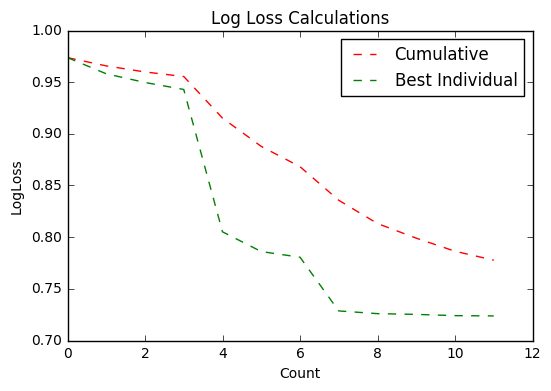

In [45]:
##plotting this here rather than in file just so simulation is stored somewhere
import matplotlib.pyplot as plt
plt.plot(range(len(logLosses)), logLosses,'r--',label='Cumulative')
plt.plot(range(len(bestLogLoss)),bestLogLoss,'g--',label='Best Individual')
plt.legend()
plt.title('Log Loss Calculations')
plt.ylabel('LogLoss')
plt.xlabel('Count')
plt.show()

The plot of the log losses show a steady decrease.  The above algorithm was run on 2,500 sample iterations.  Immediately though, we note that this process is dependent on having some "true" labels on which to calculate the log loss.  We could apply the methodology on the training set and store the models to use on the test, but given the minimal improvement in the cumulative log_loss over the more parsimonious model as well as the computational inefficiency, we choose to exclude this algorithm from the final model.  Instead, we might be better served by focusing on the categorical and text data.



Given the Renthop business set up, a large number of listings come from landlords and management companies that have multiple listings per building.  It might make sense then that there are redundancies in street address, management ID, and building ID.  We might consider translating the ID's into categorical variables and incrementally adding to our base numberical model that includes bath, bed, price, listing ID, number of photos and number of features.  A thought might be that listing ID should also be categorical, however we find that it functions more as a primary key with a unique value per row.  In order to be included in the model, we must translate the alpha-numeric ID's into pure categorical data.

In [47]:
%run LoadFiles/AdditionOfCategorical.py

With the addition of categorical variables of:
['CategoricalBuild']
The dev log-loss is 0.705
 
With the addition of categorical variables of:
['CategoricalBuild', 'CategoricalManager']
The dev log-loss is 0.705
 
With the addition of categorical variables of:
['CategoricalBuild', 'CategoricalManager', 'CategoricalStreet']
The dev log-loss is 0.702
 


From a our scoring measure of log-loss on the dev set, the inclusion of categorical varaibles seems to further improve our score which is reflcted in the test file submission as well.  Finally, we want to take a look at the final type of data:  text.  The description and feature file both lend themselves to some text analysis.  Starting first from the feautre perspective, we thought it might be a good idea to append a sparse matrix of a train set dictionary to the data frame thus far.  Given the large amount of test data relative to the train, immediate concern arises from the resulting dictionary not accurately reflecting the test lexicon.

In [48]:
%run LoadFiles/FeatureDictionarySimple.py

The dev Log-Loss is 0.67

In the dev vocabulary there are 114 words missing from the train vocabulary.


Taking one step further on the features vector yields better results that were also refelcted in the test set.  One problem this does introduce is a large increase in dimensionality with the inclusion of the sparse matrix representing the vocabulary.  We consider on the monogram dictionary limiting stop words to English to avoid some of the potential internet vocabulary adding spurious features as well as seeing if a restriction in size makes a difference.

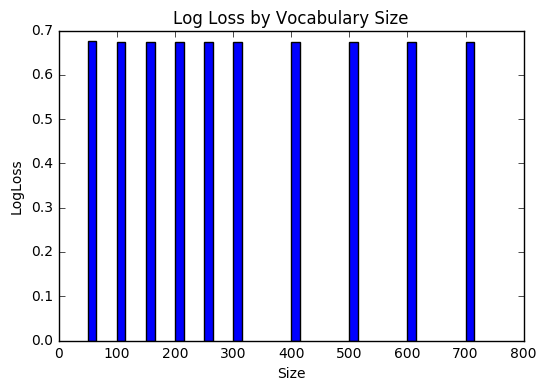

In [55]:
%run LoadFiles/FeatureDictionaryLimitFeatures.py

Intuitively we would expect the above results as there are max_features is base don frequency in corpus and there is likely a large overlap of articles, nouns, etc.  Because the feature vocabulary is fairly small, we feel comfortable accepting the model as is but applying a filtering technique on the description field.  Specifically, we want to identify the top 50 features in the high data lexicon not found in the low data.

In [57]:
%run LoadFiles/DescrptionFilter.py

The dev log loss with high-interest vocab is 0.68


By adding the vocabulary of the high interest variables we do not find an immediate boost in the perfrormance. Due to the additional dimensionality and increased computing time, we choose to exclude from the model.  Future work could definitely be done here as well as in image processing the photos.

# Evaluation and Going Forward

Having now decided on a feature set and transformation, we want to quickly evaluate other models and which classifier performs better.  The below shows our the logistic regression model discussed thus far.  The model does a fair job at predicting low and high but really does not do very well on the medium.  Due to the extremely skewed nature of the data, missing on so many mediums has hindered the overall performance.  As discussed along the way, next steps would be to delve deeper into the description and possibly image files as well as see if the score can be boosted through classifier optimization.

In [62]:
%run LoadFiles/ROCComp.py

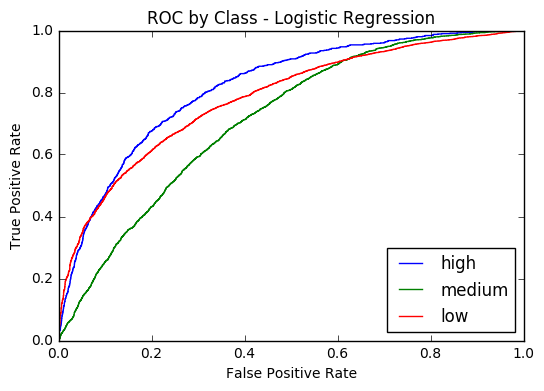

In [63]:
plt.show()